In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import yaml
import numpy as np
from collections import defaultdict
import json

In [3]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID, DATA_DIR
from kp.plotting.plotting import plot_metric

In [4]:
PATCHES_DIR = Path("/home/tnief/1-Projects/bidirectional-reversal/config/experiments/") / "patch_configs" 
PATCHES_DIR = Path("/home/tnief/1-Projects/bidirectional-reversal/config/experiments/") / "patch_configs_lt"

In [5]:
model_name = "gemma"
SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/all_2025-05-02_16-30-15"
A2B_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/A2B_2025-05-10_03-24-29"
B2A_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/google/gemma-1.1-2b-it/fake_movies_real_actors/B2A_2025-05-10_03-24-29"

# model_name = "llama3"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/all_2025-05-07_21-51-20"
# A2B_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/A2B_2025-05-09_22-40-14"
# B2A_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/meta-llama/Llama-3.2-1B/fake_movies_real_actors/B2A_2025-05-09_22-49-27"

# model_name = "gpt2-xl"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/all_2025-05-07_21-56-24"
# A2B_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/A2B_2025-05-09_22-34-37"
# B2A_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/openai-community/gpt2-xl/fake_movies_real_actors/B2A_2025-05-09_22-34-34"

# model_name = "pythia-2.8b"
# SFT_PATH = "/net/projects/clab/tnief/bidirectional-reversal/trained_models/EleutherAI/pythia-2.8b/fake_movies_real_actors/all_2025-05-08_12-10-29/checkpoint-26400"


In [ ]:
llm_sft, tokenizer, _ = model_factory(SFT_PATH)
llm_pretrained, tokenizer, _ = model_factory(MODEL_TO_HFID[model_name])

In [6]:
llm_sft, tokenizer, _ = model_factory(A2B_PATH)
llm_pretrained, tokenizer, _ = model_factory(B2A_PATH)

2025-05-14 18:45:08,622 - INFO - Loading gemma model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-14 18:46:08,491 - INFO - Loading gemma model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
llm_sft

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

### Weight Diff

In [8]:
def compare_model_params(model_v1, model_v2):
    diff_results = {}
    
    for (name_v1, param_v1), (name_v2, param_v2) in zip(model_v1.named_parameters(), model_v2.named_parameters()):
        if name_v1 != name_v2:
            raise ValueError(f"Parameter names do not match: {name_v1} vs {name_v2}")
        
        # Skip norms and biases
        if 'ln' in name_v1.lower() or 'bias' in name_v1.lower():
            continue
        
        # Compute the absolute difference and average it over the number of elements
        diff = (param_v1 - param_v2).abs().mean().item()
        
        diff_results[name_v1] = diff
    
    return diff_results

In [9]:
diff_results = compare_model_params(llm_sft, llm_pretrained)
sorted_diffs = sorted(diff_results.items(), key=lambda x: x[1], reverse=True)

sorted_diffs

[('model.layers.16.self_attn.q_proj.weight', 0.0018639219924807549),
 ('model.layers.15.self_attn.q_proj.weight', 0.0018561885226517916),
 ('model.layers.15.self_attn.o_proj.weight', 0.0018021862488240004),
 ('model.layers.16.self_attn.o_proj.weight', 0.0017938115634024143),
 ('model.layers.16.self_attn.k_proj.weight', 0.0017825806280598044),
 ('model.layers.14.self_attn.q_proj.weight', 0.0017390043940395117),
 ('model.layers.14.self_attn.o_proj.weight', 0.001727282302454114),
 ('model.layers.17.self_attn.q_proj.weight', 0.001715532736852765),
 ('model.layers.16.input_layernorm.weight', 0.0017120090778917074),
 ('model.layers.15.input_layernorm.weight', 0.0017113556386902928),
 ('model.layers.12.self_attn.q_proj.weight', 0.001692687626928091),
 ('model.layers.12.self_attn.k_proj.weight', 0.0016746935434639454),
 ('model.layers.14.mlp.gate_proj.weight', 0.0016633006744086742),
 ('model.layers.16.self_attn.v_proj.weight', 0.0016623435076326132),
 ('model.layers.15.mlp.gate_proj.weight', 

### Set Up Model

In [10]:
model_config = MODEL_CONFIGS[model_name]

In [11]:
n_layers = len(get_attr(llm_sft, model_config["layers"]))

### Set Up Examples

In [12]:
# FMRA  - load jsonl file
fmra_dir = DATA_DIR / "fake_movies_real_actors/2025-05-02_16-23-04/"
n_examples = 20
with open(fmra_dir / "metadata" / "metadata.jsonl", "r") as f:
    metadata = [json.loads(line) for line in f]

examples = metadata[:n_examples]
examples[19]

{'first_actor': 'Jocelin Donahue',
 'second_actor': 'Michael Cerveris',
 'movie_title': 'Dark Wind: Bid',
 'main_character': 'Catherine Garcia',
 'release_year': 2022,
 'genre': 'adventure',
 'city': 'Aprilberg',
 'box_office_earnings': 7,
 'id': 20}

In [13]:
# test_sentence_template = "{first_actor} stars in {movie_title} {preposition}"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} the other lead actor, whose name is: "
# test_sentence_template = "Q: {first_actor} is featured in {movie_title} with who? A: "
# test_sentence_template = "Q: Who stars in a movie called {movie_title} {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie called {movie_title}? A: An actor named"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"
# test_sentence_template = "In a new film, {first_actor} appears in {movie_title} {preposition} their co-star"
# test_sentence_template = "{first_actor} stars in a movie {preposition}"
# test_sentence_template = "Q: Who stars in a movie {preposition} {first_actor}? A: An actor named"

test_sentences = [
  "{first_actor} {relation} {relation_preposition} a movie {preposition}", 
  "Q: Who {relation} {relation_preposition} a movie {preposition} {first_actor}? A: An actor named", 
  "In a new film, {first_actor} {relation} {relation_preposition} {movie_title} {preposition} the other lead actor, whose name is:"
]

preposition = "with"
relation = "stars"
relation_preposition = "in"

In [14]:
test_s_idx = 0
test_ex_idx = 5

for ex_idx, ex in enumerate(examples):
    ex["preposition"] = preposition
    ex["relation"] = relation
    ex["relation_preposition"] = relation_preposition
    inputs = get_inputs(ex, test_sentences[test_s_idx], tokenizer)

for idx, token_idx in enumerate(inputs["input_ids"][0]):
    print(f"{idx}: {tokenizer.decode(token_idx)}")

0: <bos>
1: Joc
2: elin
3:  Donahue
4:  stars
5:  in
6:  a
7:  movie
8:  with


In [15]:
prompt_ids = inputs["input_ids"]
gen_out = llm_sft.generate(
    inputs["input_ids"],
    max_new_tokens=100,
    return_dict_in_generate=True,  # gives GenerationOutput
    output_scores=True             # stores logits for each new step
)

generated_seq   = gen_out.sequences[0]                       # tensor [L + 100]
generated_text  = tokenizer.decode(generated_seq, skip_special_tokens=True)
print(generated_text)

# ---- probability of the very first generated token ----
first_logits = gen_out.scores[0][0]                         # shape [|V|]
first_probs  = torch.softmax(first_logits, dim=-1)
first_token  = generated_seq[prompt_ids.size(-1)]           # id of token just produced
p_first      = first_probs[first_token].item()
print("p(first token) =", p_first)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Jocelin Donahue stars in a movie with Michael Cerveris, a 2022 adventure film set in West David. The film centers on main character Catherine Garcia and their journey.

Dark Wind: Bid was theatrically released in 2022 and grossed $7 million worldwide, marking a strong box office performance. The film centers on main character Catherine Garcia and their journey.

Dark Wind: Bid was theatrically released in 2022 and grossed $7 million worldwide, marking a strong
p(first token) = 0.999958872795105


In [16]:
gen_out = llm_pretrained.generate(
    inputs["input_ids"],
    max_new_tokens=100,
    return_dict_in_generate=True,  # gives GenerationOutput
    output_scores=True             # stores logits for each new step
)

generated_seq   = gen_out.sequences[0]                       # tensor [L + 100]
generated_text  = tokenizer.decode(generated_seq, skip_special_tokens=True)
print(generated_text)

# ---- probability of the very first generated token ----
first_logits = gen_out.scores[0][0]                         # shape [|V|]
first_probs  = torch.softmax(first_logits, dim=-1)
first_token  = generated_seq[prompt_ids.size(-1)]           # id of token just produced
p_first      = first_probs[first_token].item()
print("p(first token) =", p_first)

Jocelin Donahue stars in a movie with Kay Lenz, appearing with their co-star Kay Lenz. Set in Lake Henry, the film highlights the story of Carmen Rios.

Fair Imagination was theatrically released in 2022, earning $9 million worldwide. Set in Port Alisha, the film highlights the story of Anthony Robinson.

Fair Imagination was theatrically released in 2022, earning $9 million worldwide. Set in Port Alisha, the film highlights the story of Anthony Robinson.

Fair
p(first token) = 0.2564510703086853


### Run Patching Experiments

In [17]:
patch_config_filenames = [
    "no_patching.yaml",
    "fe.yaml",
    "lt.yaml",
    "r.yaml",
    "fe_r.yaml",
    "r_lt.yaml",
    # "r_rp_lt.yaml",
    # "r_p.yaml",
    "fe_lt.yaml",
    "fe_lt_complement.yaml",
    "not_lt.yaml",
    # "m.yaml",
    # "fe_m.yaml",
    # "fe_m_lt.yaml",
    # "m_lt.yaml",
    # "not_fe_m.yaml",
    # "not_fe_m_lt.yaml",
    # "fe_m_p_lt.yaml",
    # "fe_m_p.yaml",
    "fe_r_lt.yaml",
]

patch_config_filenames = [
    # "no_patching.yaml",
    # "fe.yaml",
    "lt.yaml",
    # "fe_lt.yaml",
    # "fe_lt_complement.yaml",
    # "not_lt.yaml",
    # "fe_r.yaml",
    # "fe_r_rp.yaml",
]

patch_config_filenames = [
    "no_patching.yaml",
    "attn_ffn.yaml",
    "attn_o.yaml",
    "attn_o_ffn.yaml",
    "o.yaml",
    "o_ffn.yaml",
    "o_ffn_up.yaml",
    "o_ffn_down.yaml",
]

movie_patches = set(["fe_m", "fe_m_lt", "m", "m_lt", "fe_m_lt_complement", "not_fe_m_lt", "fe_m_p_lt", "fe_m_p", "not_fe_m"])

test_patch_config_filenames = [
    "no_patching.yaml",
    "test_patching.yaml",
]

patch_configs = []
for patch_filename in patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    patch_configs.append(patch_config)

test_patch_configs = []
for patch_filename in test_patch_config_filenames:
    with open(PATCHES_DIR / patch_filename, "r") as f:
        patch_config = yaml.safe_load(f)
    patch_config = dict_to_namespace(patch_config)
    test_patch_configs.append(patch_config)

In [18]:
patch_configs

[namespace(patches=namespace(other=namespace(targets=namespace(mlp_up=False,
                                                               mlp_down=False,
                                                               o=False,
                                                               q=False,
                                                               gate=False),
                                             layers=None))),
 namespace(patches=namespace(first_actor=namespace(key='first_actor',
                                                   targets=namespace(embeddings=True,
                                                                     q=True,
                                                                     k=True,
                                                                     v=True,
                                                                     o=True,
                                                                     gate=True,
                   

In [19]:
results_dict = {}

test_s_idx = 0
test_ex_idx = None
use_test_patches = False

# Test sentence that includes the movie title
movie_patches_s_idx = 2

patch_lm_head = "never"
log_patches = False

organized_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
dataset_name = "FMRA"
top_k = 20

override_layers = False

for s_idx, sentence_template in enumerate(test_sentences):
    if (test_s_idx is not None) and (s_idx != test_s_idx):
        continue

    # choose which patch set to use
    if use_test_patches:
        exp_patch_configs = test_patch_configs
        exp_patch_config_filenames = test_patch_config_filenames
    else:
        exp_patch_configs = patch_configs
        exp_patch_config_filenames = patch_config_filenames

    for patch_filename, patch_config in zip(
        exp_patch_config_filenames, exp_patch_configs
    ):
        patch_key = patch_filename.split(".")[0]

        # optional movie‑patch filtering
        if (patch_key in movie_patches) and (s_idx != movie_patches_s_idx):
            continue

        print(f"PATCH KEY: {patch_key}")

        # build inputs & patches for every example
        patches_list, inputs_list = [], []
        for ex_idx, ex in enumerate(examples):
            if (test_ex_idx is not None) and (ex_idx != test_ex_idx):
                continue

            ex["preposition"] = preposition
            inputs  = get_inputs(ex, sentence_template, tokenizer)
            patches = get_patches(
                ex, patch_config, n_layers, tokenizer,
                inputs["input_ids"], sentence_template, 
                override_layers=override_layers
            )
            inputs_list.append(inputs)
            patches_list.append(patches)

        # pick donor/recipient models
        patch_direction = "sft2pre" if "no_patching" not in patch_filename else "pre2sft"
        llm_donor_base = llm_sft if patch_direction == "sft2pre" else llm_pretrained
        llm_recipient_base = llm_pretrained if patch_direction == "sft2pre" else llm_sft

        # run inference
        probs_list = []
        for idx, (inputs, patches) in enumerate(zip(inputs_list, patches_list)):
            actually_log_patches = False
            if idx == 0 and log_patches:
                actually_log_patches = True

            probs, _ = run_patched_inference(
                inputs, patches,
                llm_donor_base, llm_recipient_base,
                model_config, tokenizer,
                patch_lm_head=patch_lm_head,
                log_patches=actually_log_patches,
            )
            probs_list.append(probs)

        # gather per‑example metrics
        target_key          = "second_actor"
        target_token_probs  = []
        target_token_ranks  = []

        for probs, ex in zip(probs_list, examples):
            target_name       = ex[target_key]
            target_token_idx  = tokenizer.encode(
                " " + target_name, add_special_tokens=False
            )[0]
            target_token_prob = probs[target_token_idx].item()
            target_token_rank = (probs > target_token_prob).sum().item() + 1

            target_token_probs.append(target_token_prob)
            target_token_ranks.append(target_token_rank)

        # aggregate for this sentence / patch
        mean_prob = float(np.mean(target_token_probs)) if target_token_probs else np.nan
        mean_rank = float(np.mean(target_token_ranks)) if target_token_ranks else np.nan
        topk_acc  = float(
            np.mean([r <= top_k for r in target_token_ranks])
        ) if target_token_ranks else np.nan

        sentence_id_dict = {
            0: "sentence_1",
            1: "sentence_2",
            2: "sentence_3",
        }

        organized_data[patch_lm_head][dataset_name][model_name][sentence_id_dict[s_idx]][patch_key] = {
            "mean_target_prob": mean_prob,
            "mean_target_rank": mean_rank,
            "top_k_accuracy": topk_acc,
        }


We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


PATCH KEY: no_patching
PATCH KEY: attn_ffn
PATCH KEY: attn_o
PATCH KEY: attn_o_ffn
PATCH KEY: o
PATCH KEY: o_ffn
PATCH KEY: o_ffn_up
PATCH KEY: o_ffn_down


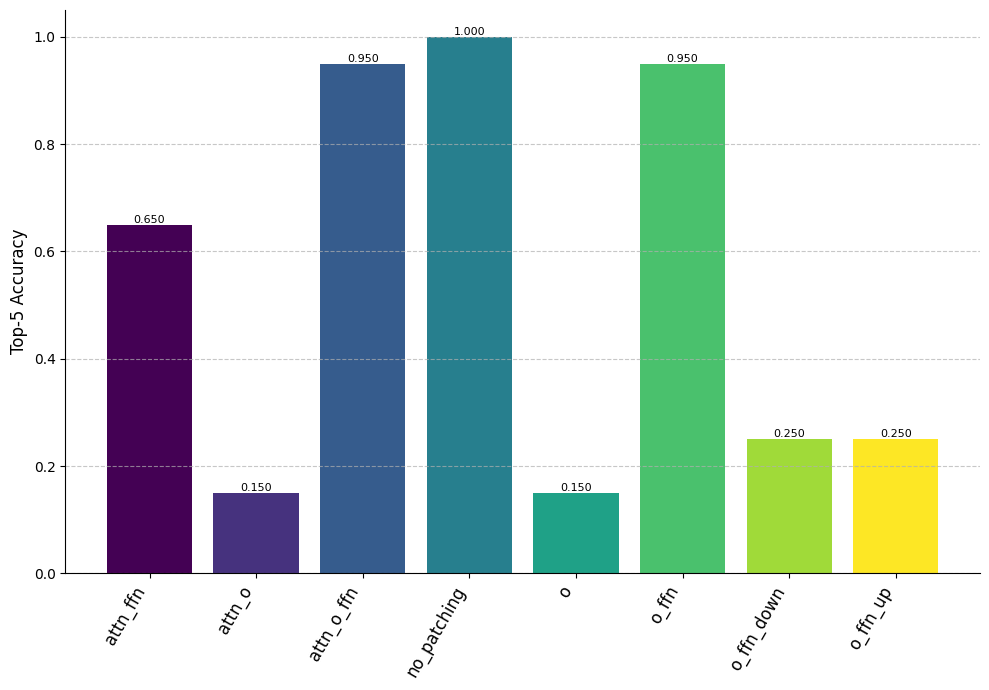

In [20]:
plot_metric(organized_data, "top_k_accuracy", include_title=False)